## Main work starts from this point (PREPROCESSING)

In [1]:
import os
import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time

In [2]:
df = pd.read_csv("annotations_df.csv")
df = df.head(20) # change the size!!!!!!!1!!

In [3]:
image_dir = 'F:/BU/2024 Spring/CS777/term_project/project_data' #change the directory to your dataset
image_size = 416

In [4]:
############ PREPROCESSING STEP #####################

In [5]:
def preprocess_dataset(df):
    labels = []
    boxes = []
    img_list = []
    for index, row in df.iterrows():
        labels.append([row['category_id']])
        scaled_box = [
            row['bbox_x_min'] / row['width'],
            row['bbox_y_min'] / row['height'],
            (row['bbox_x_min'] + row['bbox_width'])/row['width'],
            (row['bbox_y_min'] + row['bbox_height'])/row['height']
        ]
        boxes.append([scaled_box])
        img_path = row['filename']
        img = cv2.imread(os.path.join(image_dir, img_path))
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype("float32") / 255.0
            img_list.append(img)
    return labels, boxes, img_list

In [6]:
labels, boxes, img_list = preprocess_dataset(df)

In [7]:
img_list = np.array(img_list)
labels = np.array(labels)
boxes = np.array(boxes)

indices = np.arange(len(labels))
np.random.shuffle(indices)

img_list = img_list[indices]
labels = labels[indices]
boxes = boxes[indices]

In [8]:
train_images, test_images, train_labels, test_labels, train_boxes, test_boxes = train_test_split(img_list, labels, boxes, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split(train_images, train_labels, train_boxes, test_size=0.25, random_state=42)

In [9]:
print('Training Images Count: {}, Validation Images Count: {}, Test Images Count: {}'.format(len(train_images), len(val_images), len(test_images)))

Training Images Count: 12, Validation Images Count: 4, Test Images Count: 4


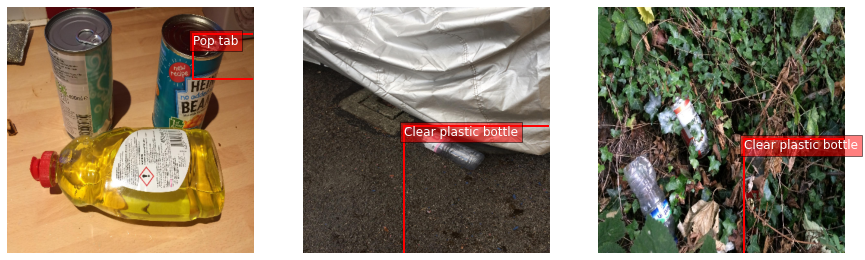

In [10]:
def show_images_with_boxes(img_list, boxes, labels, categories, num_images=3):
    indices = [0]
    indices += random.sample(range(1, len(img_list)), num_images - 1)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs]
    for i, ax in zip(indices, axs):
        img = img_list[i]
        box = boxes[i][0]
        label = labels[i][0]
        ax.imshow(np.uint8(img * 255))
        x = box[0] * image_size
        y = box[1] * image_size
        width = box[2] * image_size
        height = box[3] * image_size
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        category_name = categories[label]
        ax.text(x, y, category_name, color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
        ax.axis('off')
    plt.show()

category_dict = {id: name for id, name in zip(df['category_id'], df['category'])}
show_images_with_boxes(img_list, boxes, labels, category_dict, num_images=3)

## Faster R-CNN Model

In [11]:
### preparing the dataset for the model
### the input data should be image and the dictionary of boxes and labels

In [12]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, boxes):
        self.images = torch.tensor(images, dtype=torch.float).permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.long).squeeze()
        self.boxes = torch.tensor(boxes, dtype=torch.float).squeeze()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        box = self.boxes[idx]
        
        target = {
            'boxes': box,
            'labels': label
        }

        return image, target

In [13]:
train_dataset = CustomDataset(train_images, train_labels, train_boxes)
val_dataset = CustomDataset(val_images, val_labels, val_boxes)
test_dataset = CustomDataset(test_images, test_labels, test_boxes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
### construct the model

In [15]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

In [16]:
def get_model(num_classes):
    # Load a pre-trained model for feature extraction
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [20]:
# Initialize the Model
num_classes = df['category_id'].nunique() + 1  # +1 for the background class
# num_classes = 59  # this is the overall unique classes of whole dataset, use this if the num_classes is less than 59
model = get_model(num_classes)

In [21]:
num_classes

59

In [19]:
# Define Optimizer and Learning Parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [22]:
# Move the Model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=num_classes)  
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
### Train the model
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        targets = [{k: v[i].to(device) for k, v in targets.items()} for i in range(len(images))]
        adjusted_targets = [{'boxes': item['boxes'].unsqueeze(0), 
                         'labels': torch.tensor([item['labels']]) if not isinstance(item['labels'], torch.Tensor) else item['labels'].unsqueeze(0) if item['labels'].dim() == 0 else item['labels']}
                        for item in targets]

        loss_dict = model(images, adjusted_targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
                
        print(f"Epoch {epoch+1} loss: {losses.item()}")

In [24]:
data_loader = train_loader
# Training the model for 10 epochs
for epoch in range(10):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

Epoch 1 loss: 7.423857688903809
Epoch 2 loss: 7.428025245666504
Epoch 3 loss: 7.427529335021973
Epoch 4 loss: 7.424593925476074
Epoch 5 loss: 7.421372413635254
Epoch 6 loss: 7.41825008392334
Epoch 7 loss: 7.419089317321777
Epoch 8 loss: 7.42697811126709
Epoch 9 loss: 7.428171157836914
Epoch 10 loss: 7.427267074584961


In [25]:
### Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0

    with torch.no_grad():  # Do not compute gradient
        for images, targets in test_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v[i].to(device) for k, v in targets.items()} for i in range(len(images))]
            adjusted_targets = [{'boxes': item['boxes'].unsqueeze(0), 
                         'labels': torch.tensor([item['labels']]) if not isinstance(item['labels'], torch.Tensor) else item['labels'].unsqueeze(0) if item['labels'].dim() == 0 else item['labels']}
                        for item in targets]

            outputs = model(images)

            for output, target in zip(outputs, adjusted_targets):
                predicted_labels = output['labels']
                true_labels = target['labels']

                _, predicted = torch.max(predicted_labels, -1)  # Get the predicted class labels
                total += true_labels.size(0)
                correct += (predicted == true_labels).sum().item()

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [26]:
### train dataset
train_accuracy = evaluate_model(model, train_loader, device)

In [30]:
print(f"Train Accuracy: {train_accuracy}")

Train Accuracy: 0.0


In [27]:
### test dataset
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.25


In [28]:
### validate dataset
validate_accuracy = evaluate_model(model, val_loader, device)
print(f"Validate Accuracy: {validate_accuracy}")

Validate Accuracy: 0.0


In [ ]:
### Visualization

In [29]:
import json
anns_file_path = 'F:/BU/2024 Spring/CS777/term_project/project/annotations.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

In [30]:
def visualize_predictions(test_loader, model, categories):
    model.eval()
    images_to_show = []
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(test_loader):
            
            images = [image.to(device) for image in images]
            outputs = model(images)
            
            for img, output in zip(images, outputs):
                probabilities = output['scores']
                top_score, top_idx = probabilities.max(dim=0)               

                predicted_label = output['labels'][top_idx]
                predicted_box = output['boxes'][top_idx].cpu().numpy()
                
                img_np = img.cpu().numpy().transpose(1, 2, 0)  # CHW to HWC
                img_np = (img_np * 255).astype(np.uint8)
                
                images_to_show.append((img_np, predicted_box, predicted_label.item(), top_score.item()))

    fig, axs = plt.subplots(1, len(images_to_show), figsize=(15, 5))
    for i, (img, box, label_id, confidence) in enumerate(images_to_show):
        label = categories[label_id]['name'] if label_id < len(categories) else 'Unknown'
        confidence_text = f"{label} ({confidence:.2f})"
        ax = axs[i]
        ax.imshow(img)
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], confidence_text, color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
        ax.axis('off')

    plt.show()    

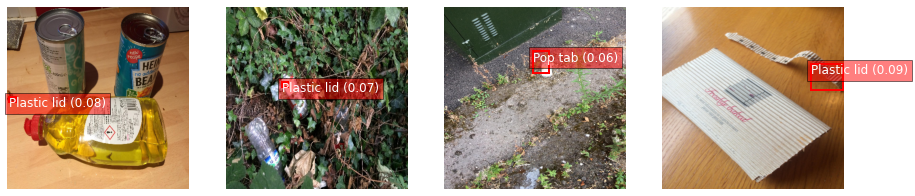

In [31]:
try:
    visualize_predictions(test_loader, model, categories)
except ValueError as e:
    print(e)

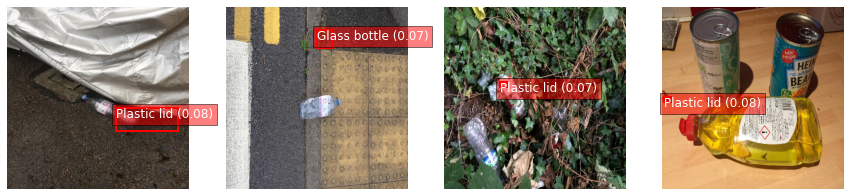

In [32]:
try:
    visualize_predictions(val_loader, model, categories)
except ValueError as e:
    print(e)